In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cartopy
import cartopy.crs as ccrs
import networkx as nx
import netgraph

In [2]:
def subdivide_edge(edges: np.ndarray, num_points: int) -> np.ndarray:
    """Subdivide edges into num_points segments.

     The points being uniformly distributed, as if walking along the line.

    Parameters
    ----------
    edges : array-like, shape (n_edges, current_points, 2)
        The edges to subdivide.
    num_points : int
        The number of points to generate along each edge.

    Returns
    -------
    new_points : array-like, shape (n_edges, num_points, 2)

    """
    segment_vecs = edges[:, 1:] - edges[:, :-1]
    segment_lens = np.linalg.norm(segment_vecs, axis=-1)
    cum_segment_lens = np.cumsum(segment_lens, axis=1)
    cum_segment_lens = np.hstack(
        [np.zeros((cum_segment_lens.shape[0], 1)), cum_segment_lens]
    )

    total_lens = cum_segment_lens[:, -1]

    # At which lengths do we want to generate new points
    t = np.linspace(0, 1, num=num_points, endpoint=True)
    desired_lens = t * total_lens[:, None]
    # Which segment should the new point be interpolated on
    i = np.argmax(desired_lens[:, None] < cum_segment_lens[..., None], axis=1)
    # At what percentage of the segment does this new point actually appear
    pct = (desired_lens - np.take_along_axis(cum_segment_lens, i - 1, axis=-1)) / (
        np.take_along_axis(segment_lens, i - 1, axis=-1) + 1e-8
    )

    row_indices = np.arange(edges.shape[0])[:, None]
    new_points = (
        (1 - pct[..., None]) * edges[row_indices, i - 1]
        + pct[..., None] * edges[row_indices, i]
    )

    return new_points


def compute_edge_compatibility(edges: np.ndarray) -> np.ndarray:
    """Compute pairwise-edge compatibility scores.

    Parameters
    ----------
    edges : array-like, shape (n_edges, n_points, 2)
        The edges to compute compatibility scores for.

    Returns
    -------
    compat : array-like, shape (n_edges, n_edges)
        The pairwise edge compatibility scores.

    """
    vec = edges[:, -1] - edges[:, 0]
    vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)

    # Angle comptability
    compat_angle = np.abs((vec @ vec.T) / (vec_norm @ vec_norm.T + 1e-8))

    # Length compatibility
    l_avg = (vec_norm + vec_norm.T) / 2
    compat_length = 2 / (
        l_avg / (np.minimum(vec_norm, vec_norm.T) + 1e-8)
        + np.maximum(vec_norm, vec_norm.T) / (l_avg + 1e-8)
        + 1e-8
    )

    # Distance compatibility
    midpoint = (edges[:, 0] + edges[:, -1]) / 2
    midpoint_dist = np.linalg.norm(midpoint[None, :] - midpoint[:, None], axis=-1)
    compat_dist = l_avg / (l_avg + midpoint_dist + 1e-8)

    # Visibility compatibility
    # Project point endpoints onto the line segment:
    #   t = a*p / ab*ab
    #   proj = a + t*ab
    ap = edges[None, ...] - edges[:, None, None, 0]
    t = np.sum(ap * vec[:, None, None, :], axis=-1) / (
        np.sum(vec**2, axis=-1)[:, None, None] + 1e-8
    )
    I = edges[:, None, 0, None] + t[..., None] * vec[:, None, None, :]

    i0, i1 = I[..., 0, :], I[..., 1, :]
    Im = (i0 + i1) / 2

    denom = np.sqrt(np.sum((i0 - i1) ** 2, axis=-1))
    num = 2 * np.linalg.norm(midpoint[:, None, ...] - Im, axis=-1)

    compat_visibility = np.maximum(0, 1 - num / (denom + 1e-8))
    compat_visibility = np.minimum(compat_visibility, compat_visibility.T)

    # Combine compatibility scores
    return compat_angle * compat_length * compat_dist * compat_visibility

In [3]:
def compute_forces(e: np.ndarray, e_compat: np.ndarray, kp: np.ndarray) -> np.ndarray:
    # Left-mid spring direction
    v_spring_l = e[:, :-1] - e[:, 1:]
    v_spring_l = np.concatenate(
        [np.zeros((v_spring_l.shape[0], 1, v_spring_l.shape[-1])), v_spring_l],
        axis=1,
    )

    # Right-mid spring direction
    v_spring_r = e[:, 1:] - e[:, :-1]
    v_spring_r = np.concatenate(
        [v_spring_r, np.zeros((v_spring_l.shape[0], 1, v_spring_l.shape[-1]))],
        axis=1,
    )

    f_spring_l = np.sum(v_spring_l**2, axis=-1, keepdims=True)
    f_spring_r = np.sum(v_spring_r**2, axis=-1, keepdims=True)

    F_spring = kp * (f_spring_l * v_spring_l + f_spring_r * v_spring_r)

    # Electrostatic force
    v_electro = e[:, None, ...] - e[None, ...]
    f_electro = e_compat[..., None] / (np.linalg.norm(v_electro, axis=-1) + 1e-8)

    F_electro = np.sum(f_electro[..., None] * v_electro, axis=0)

    F = F_spring + F_electro
    # The first and last points are fixed
    F[:, 0, :] = F[:, -1, :] = 0

    return F


In [4]:
def wfdeb(
    edges: np.ndarray,
    W = None, 
    K = .1,
    n_iter: int = 60,
    n_iter_reduction: float = 2 / 3,
    lr: float = 0.04,
    lr_reduction: float = 0.5,
    n_cycles: int = 6,
    initial_segpoints: int = 1,
    segpoint_increase: float = 2,
    compat_threshold: float = 0.5,
) -> np.ndarray:
    """Run the Weighted Force-Directed Edge Bundling algorithm.

    Parameters
    ----------
    edges: array-like, shape (n_edges, 2, 2)
        The edge points.
    K: float or array-like, shape (n_edges,)
        The spring constant for each edge. If a float is provided, all edges
        will have the same spring constant.
    n_iter: int
        The number of iterations to run in the first cycle.
    n_iter_reduction: float
        The factor by which to reduce the number of iterations in each cycle.
    lr: float
        The learning rate.
    lr_reduction: float
        The factor by which to reduce the learning rate in each cycle.
    n_cycles: float
        The number of cycles to run the algorithm for. In each cycle, the number
        of segments is increased by a factor `segpoint_increase`.
    initial_segpoints: int
        The initial number of segments to start with.
    segpoint_increase: float
        The factor by which to increase the number of segments in each cycle.
    compat_threshold: float
        Edge interactions with compatibility lower than a specified threshold
        are ignored.

    Returns
    -------
    edges: array-like, shape (n_edges, n_segments + 1, 2)

    """

    # Initial edge properties
    initial_edge_vecs = edges[:, 0] - edges[:, -1]
    initial_edge_lengths = np.linalg.norm(initial_edge_vecs, axis=-1, keepdims=True)

    # Compute edge compatibilities
    edge_compatibilities = compute_edge_compatibility(edges)
    edge_compatibilities = (edge_compatibilities > compat_threshold).astype(np.float32)

    num_segments = initial_segpoints

    for cycle in tqdm(range(n_cycles)):
        # Subdivide edges
        edges = subdivide_edge(edges, num_segments + 2)  # Add 2 for endpoints
        num_segments = int(np.ceil(num_segments * segpoint_increase))

        # Calculate spring constant per edge
        kp = (K / (initial_edge_lengths * num_segments + 1e-8)).flatten()
        if W is not None:
            kp = kp * W
        kp = kp[..., None, None]  # Reshape kp to have the shape (84, 1, 1)
        # return kp

        for epoch in range(n_iter):
            F = compute_forces(edges, edge_compatibilities, kp)
            edges += F * lr

        # Adjust iterations and learning rate
        n_iter = int(np.ceil(n_iter * n_iter_reduction))
        lr = lr * lr_reduction

    return edges


# Reinventing the wheel

In [5]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [6]:
credentials = service_account.Credentials.from_service_account_file('C:\\Users\\elija\\Documents\\24f-coop\\credentials.json')
project = 'net-data-viz-handbook'

# Initialize a GCS client
client = bigquery.Client(credentials=credentials, project=project)

In [7]:
q = """
SELECT 
  i.source_basin, 
  g1.basin_label AS source_basin_label,
  g1.latitude AS source_lat, g1.longitude AS source_lon, 
  g2.latitude AS lat, g2.longitude AS lon, 
  i.target_basin, 
  g2.basin_label AS target_basin_label,
  SUM(i.importations) AS exportations
FROM 
  `net-data-viz-handbook.importation_data.sir_importations_1` AS i
JOIN 
  `net-data-viz-handbook.reference.gleam-geo-map` AS g1
ON 
  g1.basin_id = i.source_basin
JOIN 
  `net-data-viz-handbook.reference.gleam-geo-map` AS g2
ON 
  g2.basin_id = i.target_basin
-- WHERE 
--  g1.country_id = 218 OR g2.country_id = 218
GROUP BY 
  i.source_basin, 
  i.target_basin,
  g1.basin_label,
  g2.basin_label,
  g2.latitude, 
  g2.longitude,
  g1.latitude, 
  g1.longitude
HAVING
  SUM(i.importations) > 1500

"""

# Run the query
query_job = client.query(q)

# Fetch the results into a pandas DataFrame
results = query_job.result().to_dataframe()

# Display the first few rows
results.head()

,source_basin,source_basin_label,source_lat,source_lon,lat,lon,target_basin,target_basin_label,exportations
0,1024,MexicoCity,19.4364,-99.0722,25.7786,-100.1069,1032,Monterrey,2507
1,1024,MexicoCity,19.4364,-99.0722,21.0367,-86.8772,1036,Cancun,2767
2,1024,MexicoCity,19.4364,-99.0722,20.5217,-103.3111,1023,Guadalajara,1893
3,1036,Cancun,21.0367,-86.8772,19.4364,-99.0722,1024,MexicoCity,2731
4,1032,Monterrey,25.7786,-100.1069,19.4364,-99.0722,1024,MexicoCity,2359


In [8]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for idx, row in results.iterrows():
    G.add_edge(row['source_basin_label'], row['target_basin_label'], weight=row['exportations'])

In [9]:
q = """
WITH filtered_importations AS ( --this is the same query as above
  SELECT 
    i.source_basin, 
    g1.basin_label AS source_basin_label,
    g1.latitude AS source_lat, 
    g1.longitude AS source_lon, 
    g2.latitude AS lat, 
    g2.longitude AS lon, 
    i.target_basin, 
    g2.basin_label AS target_basin_label,
    SUM(i.importations) AS exportations
  FROM 
    `net-data-viz-handbook.importation_data.sir_importations_1` AS i
  JOIN 
    `net-data-viz-handbook.reference.gleam-geo-map` AS g1
  ON 
    g1.basin_id = i.source_basin
  JOIN 
    `net-data-viz-handbook.reference.gleam-geo-map` AS g2
  ON 
    g2.basin_id = i.target_basin
--  WHERE 
--    g1.country_id = 218 OR g2.country_id = 218
  GROUP BY 
    i.source_basin, 
    i.target_basin,
    g1.basin_label,
    g2.basin_label,
    g2.latitude, 
    g2.longitude,
    g1.latitude, 
    g1.longitude
  HAVING
    SUM(i.importations) > 1500
)

-- Get unique basins for node_layout
SELECT DISTINCT
  source_basin_label AS basin_label, 
  source_lon AS lon, 
  source_lat AS lat
FROM filtered_importations

UNION DISTINCT

SELECT DISTINCT
  target_basin_label AS basin_label, 
  lon AS lon, 
  lat AS lat
FROM filtered_importations

"""

# Run the query
query_job = client.query(q)

# Fetch the results into a pandas DataFrame
all_basins = query_job.result().to_dataframe()

# Create the node_layout dictionary
node_layout = dict(zip(all_basins['basin_label'], np.array(list(zip(all_basins['lon'], all_basins['lat'])))))
scaled_pos = {basin: np.array((coords[0]/180, coords[1]/180)) for basin, coords in node_layout.items()}

# Check the result
scaled_pos

{'Monterrey': array([-0.55614944,  0.14321444]),
 'Cancun': array([-0.48265111,  0.11687056]),
 'Guadalajara': array([-0.57395056,  0.11400944]),
 'MexicoCity': array([-0.55040111,  0.10798   ]),
 'Seoul': array([0.70250333, 0.20816222]),
 'Medellin': array([-0.41901722,  0.03424667]),
 'Vancouver': array([-0.68435778,  0.27329944]),
 'Toronto': array([-0.44239222,  0.24265111]),
 'Cali': array([-0.42434278,  0.019685  ]),
 'Bogota': array([-0.41192722,  0.02612056]),
 'Cartagena': array([-0.41951722,  0.05801389]),
 'London(UK)': array([-0.00256333,  0.28598611]),
 'Pusan': array([0.71701556, 0.19522389]),
 'Calgary': array([-0.63344611,  0.28396611]),
 'Cheongju': array([0.70832889, 0.20398167]),
 'HongKong': array([0.63285944, 0.12393833]),
 'Paris': array([0.01415444, 0.27227611]),
 'SaoPaulo': array([-0.25816333, -0.13017722]),
 'Jeju': array([0.70273944, 0.18617444]),
 'Cuzco': array([-0.39966056, -0.07519889]),
 'SanFrancisco': array([-0.67995389,  0.20899389]),
 'Shanghai': arr

In [10]:
edges = tuple(zip(results['source_basin_label'], results['target_basin_label']))

In [11]:
from fdeb import fdeb

In [35]:
weights = ((results['exportations'].values).to_numpy() / results['exportations'].max())**2
weights
dec = np.array([scaled_pos[y] for x in edges for y in x]).reshape(-1, 2, 2)
fdeb_paths = dict(zip(edges, wfdeb(dec, 
                                  lr=.004, lr_reduction=.5, K=-44, \
                                  # W=weights,
                                  compat_threshold=.75, n_cycles = 6,
                                 )*180))

  0%|          | 0/6 [00:00<?, ?it/s]

In [36]:
def normalize_dict_values(input_dict):
    # Get the minimum and maximum values from the dictionary
    min_val = min(input_dict.values())
    max_val = max(input_dict.values())
    
    # Normalize values
    normalized_dict = {
        key: ((value - min_val) / (max_val - min_val))*1 for key, value in input_dict.items()
    }
    
    return normalized_dict

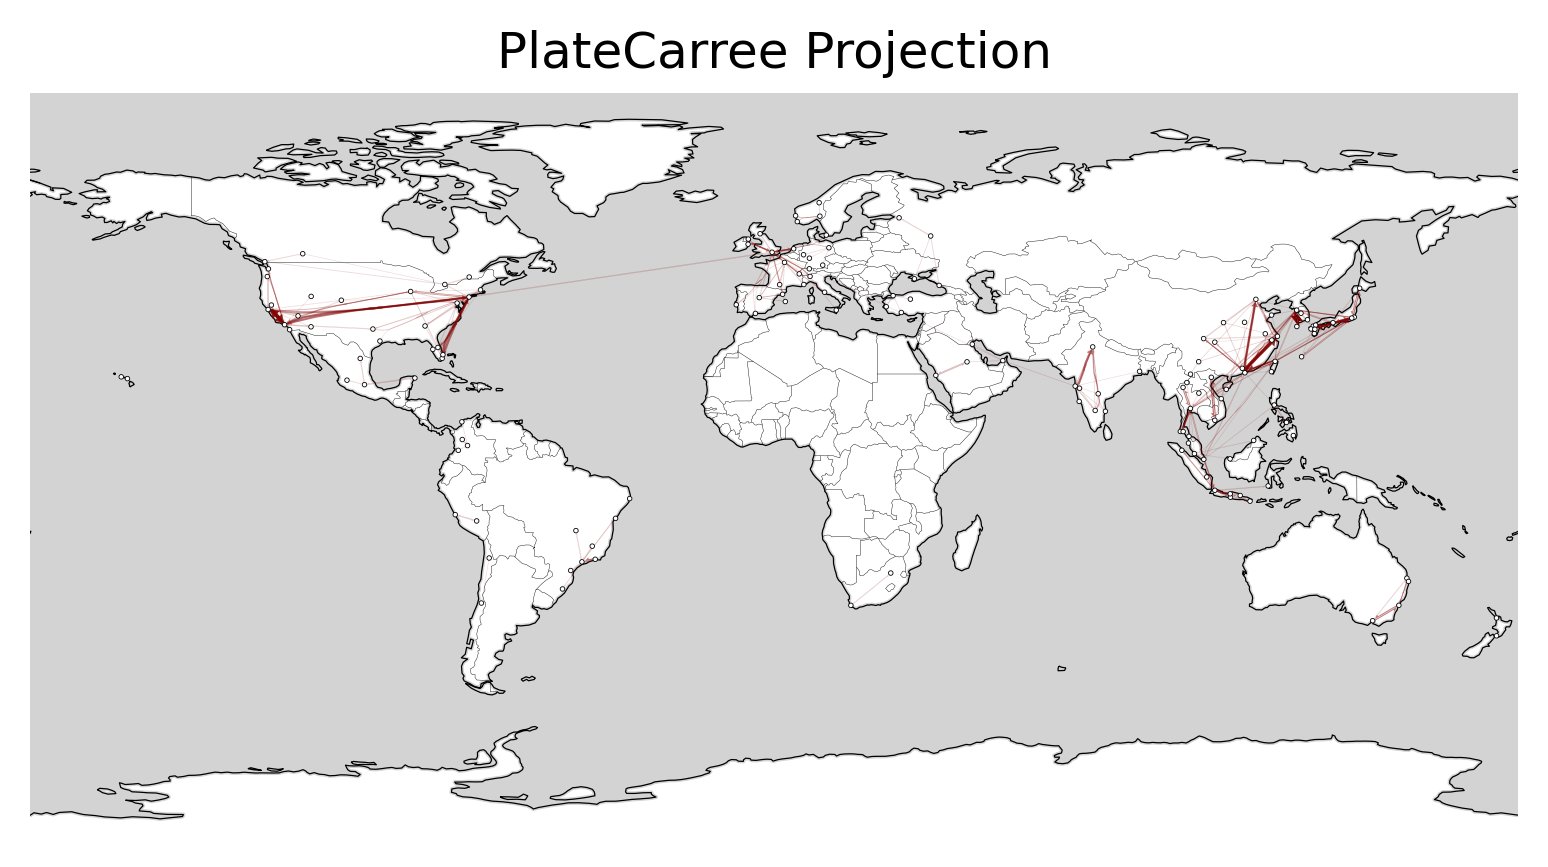

In [37]:
weights = dict(zip(tuple(zip(results['source_basin_label'], results['target_basin_label'])), results['exportations']))
weights['arbmin'] = 0
norm_weights = normalize_dict_values(weights)

"https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html"
projection = ccrs.PlateCarree

# Create a map using Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': projection(central_longitude=0)}, dpi=300)
# ax.set_extent([-170, -60, 15, 40]) # US
# ax.set_extent([-30, 30, 35, 60]) # Europe
# ax.set_extent([80, 150, -10, 50]) # East Asia
ax.set_extent([-180, 180, -90, 90]) # world

# Add features to the map (coastlines, borders, etc.)
# uses https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.feature_artist.FeatureArtist.html

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.1,)
ax.add_feature(cartopy.feature.OCEAN, color='lightgray')
# ax.add_feature(cartopy.feature.LAKES, color='lightgray')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=.3,)
# ax.add_feature(cartopy.feature.STATES, linestyle='-', linewidth=.1)
# ax.stock_img()

netgraph.Graph(
    G,
    node_layout=node_layout,
    edge_width={key: value*100 for key, value in norm_weights.items()},
    node_edge_width=20,
    node_size=65,
    node_edge_color='black',
    node_labels=False,
    arrows=True,
    edge_color='maroon',
    edge_layout=fdeb_paths,
    edge_alpha={key: value*1 for key, value in norm_weights.items()},
    prettify=True,
    ax=ax,  # Plot on the same axes as the map
)

# for nodes, path in fdeb_paths.items():
#     ax.plot(path[:, 0], path[:, 1],
#             # color=cmap(norm_weights[nodes]),
#             color='maroon',
#             linewidth=norm_weights[nodes]*3,
#             alpha=max(min((norm_weights[nodes]**1/3)*5, .4), 0),
#             transform=ccrs.PlateCarree()
#             )
    
    
# for node, loc in node_layout.items():
    
#     # circular node
#     ax.plot(loc[0], loc[1], 
#             'o', color='navy', markersize=4,
#             markeredgecolor='black', markeredgewidth=0,
#             transform=ccrs.PlateCarree())
    
#     # Add text above the node with a box
#     ax.text(loc[0], loc[1] + 0, node, 
#             fontsize=5, fontweight='bold', color = '#4a4a4a',
#             ha='center', va='bottom', 
#             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
#             transform=ccrs.PlateCarree())

plt.title(f'{projection.__name__} Projection')
plt.savefig('worldexample')
plt.show()

In [38]:
fdeb_paths[('LosAngeles', 'SanFrancisco')] - fdeb_paths[('SanFrancisco', 'LosAngeles')][::-1]

array([[ 0.        ,  0.        ],
       [ 0.00059317, -0.00067126],
       [ 0.00123299, -0.00130104],
       [ 0.00190005, -0.00188768],
       [ 0.00270377, -0.00222249],
       [ 0.00514441,  0.00484164],
       [-0.03677305,  0.00333786],
       [ 0.00591304, -0.00139182],
       [ 0.00608105, -0.00273216],
       [ 0.00641108, -0.00306233],
       [ 0.00564824, -0.00428797],
       [ 0.00873074, -0.00138901],
       [ 0.0048044 , -0.00501684],
       [ 0.01704219, -0.00061776],
       [ 0.01663146,  0.01619477],
       [ 0.01302214, -0.03774589],
       [ 0.04981234,  0.03587548],
       [-0.00930857,  0.02447338],
       [ 0.00859279,  0.03464185],
       [-0.012764  ,  0.00310156],
       [-0.00462371,  0.01107065],
       [-0.00595726,  0.00902859],
       [-0.00730333,  0.00695687],
       [-0.00622873,  0.00642151],
       [-0.00633808,  0.00486913],
       [-0.00439876,  0.00546937],
       [-0.00209385,  0.00266727],
       [-0.00165796,  0.00147793],
       [-0.00203688,

In [39]:
fdeb_paths[('Chicago', 'NewYork')] - fdeb_paths[('NewYork', 'Chicago')][::-1]

array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.79196722e-06,  1.69849834e-07],
       [-1.79196759e-06,  1.69849862e-07],
       [-1.79196830e-06,  1.69849912e-07],
       [-1.79196846e-06,  1.69849919e-07],
       [-1.79196847e-06,  1.69849898e-07],
       [-1.79196843e-06,  1.69849883e-07],
       [-1.79196847e-06,  1.69849869e-07],
       [-1.79196846e-06,  1.69849855e-07],
       [-1.79196843e-06,  1.69849848e-07],
       [-1.79196843e-06,  1.69849827e-07],
       [-1.79196840e-06,  1.69849812e-07],
       [-1.79196840e-06,  1.69849805e-07],
       [-1.79196834e-06,  1.69849798e-07],
       [-1.79196817e-06,  1.69849820e-07],
       [-1.79196753e-06,  1.69849798e-07],
       [-1.79194137e-06,  1.69847397e-07],
       [-1.79194136e-06,  1.69847389e-07],
       [-1.79196755e-06,  1.69849791e-07],
       [-1.79196817e-06,  1.69849820e-07],
       [-1.79196834e-06,  1.69849791e-07],
       [-1.79196840e-06,  1.69849791e-07],
       [-1.79196840e-06,  1.69849791e-07],
       [-1.